# Unsupervised Capstone: Classifying Authors
### By Carley Fletcher

My Unsupervised Capstone project is working to classify authors by their texts using natural language processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import re
import csv
from scipy import stats, integrate
%matplotlib inline

from nltk.corpus import gutenberg, stopwords
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

### Loading the Dataset

For this capstone I picking a set of texts from 10 different authors that had a least 100 datapoints for each author. I chose 10 authors from the Gutenberg corpus. Each of these authors is a well know classic and their books were either novels or poetry.

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Load the books and reading in the data, this time in the form of paragraphs
austen = gutenberg.paras('austen-persuasion.txt')
blake = gutenberg.paras('blake-poems.txt')
bryant = gutenberg.paras('bryant-stories.txt')
burgess = gutenberg.paras('burgess-busterbrown.txt')
carroll = gutenberg.paras('carroll-alice.txt')
chesterton = gutenberg.paras('chesterton-ball.txt')
edgeworth = gutenberg.paras('edgeworth-parents.txt')
melville = gutenberg.paras('melville-moby_dick.txt')
milton = gutenberg.paras('milton-paradise.txt')
whitman = gutenberg.paras('whitman-leaves.txt')

In [4]:
book_list = [edgeworth, melville, whitman, chesterton, bryant, austen, carroll, blake, burgess, milton]

### Creating a Dataframe

Here I am going to separate each text into paragraphs for each author. This will then allow me to perform the classification and natural language processing on these individual paragraphs. 

In [5]:
# Create an empty dataframe for the paragraph texts and authors
paragraph_df = pd.DataFrame()

In [6]:
#processing
paragraph_list = []
author_list = []

for book in book_list:
    # Loop through each paragraph
    for paragraphs in book:
        # If the paragraph has only one sentence then it is likely a Chapter or Title
        if len(paragraphs) == 1:
            # Loop through the words of this single sentence paragraph
            for words in paragraphs:
                # Only use it if there are more than 2 words in it. 
                if len(words) > 2:
                    para=paragraphs[0]
                    # removing the double-dash from all words
                    para=[re.sub(r'--','',word) for word in para]
                    # Forming each paragraph into a string and adding it to the list of strings.
                    paragraph_list.append(' '.join(para))
                    # Each time a paragraph is appended, add the corresponding author to another list
                    author_list.append('{}'.format(book[0][0]))
        # Carry out the same process for all paragraphs that have more than one sentence. 
        else:
            para=paragraphs[0]
            #removing the double-dash from all words
            para=[re.sub(r'--','',word) for word in para]
            #Forming each paragraph into a string and adding it to the list of strings.
            paragraph_list.append(' '.join(para))
            author_list.append('{}'.format(book[0][0]))        

In [7]:
# Now clean up the paragraphs in the lists
clean_list = []
for each in paragraph_list:
    each = re.sub(r'\s+([\'-;,?.!"])', r'\1', each)
    each = "".join(each.split("} "))
    each = "'".join(each.split("\' "))
    each = "-".join(each.split("- "))
    clean_list.append(each)

In [8]:
# Add these clean paragraphs and authors to the dataframe
paragraph_df['paragraphs'] = clean_list
paragraph_df['authors'] = author_list

In [9]:
# Make a column with an encoded label for each author
lb_make = LabelEncoder()
paragraph_df['author_codes'] = lb_make.fit_transform(paragraph_df['authors'])

In [10]:
# Completed Dataframe
paragraph_df.head()

,paragraphs,authors,author_codes
0,"[ The Parent's Assistant, by Maria Edgeworth ]","['[', 'The', 'Parent', ""'"", 's', 'Assistant', ...",9
1,THE ORPHANS.,"['[', 'The', 'Parent', ""'"", 's', 'Assistant', ...",9
2,"Near the ruins of the castle of Rossmore, in I...","['[', 'The', 'Parent', ""'"", 's', 'Assistant', ...",9
3,Mary was at this time about twelve years old.,"['[', 'The', 'Parent', ""'"", 's', 'Assistant', ...",9
4,""" No need to stop the wheel, Mary, dear, for m...","['[', 'The', 'Parent', ""'"", 's', 'Assistant', ...",9


### Exploring Author Characteristics

In [11]:
# Create an dataframe for the analyzing the authors
author_count_df = pd.DataFrame()

In [12]:
# A Column with each author listed
author_count_df['authors'] = ['edgeworth', 'melville', 'whitman', 'chesterton', 'bryant', 'austen', 'carroll', 'blake', 'burgess', 'milton']

In [13]:
# This is a function to cound the average length of each book's paragraphs
def average_paragraph_length(book):
    total = 0
    count = 0
    for paragraphs in book:
        #If the length of the paragraph is one then it is likely a Chapter or Title
        if len(paragraphs) == 1:
            for words in paragraphs:
                # Only use it if there are more than 2 words in it. 
                if len(words) > 2:
                    # Add the length of this paragraph to the total
                    total += len(paragraphs)
                    # Increase the count by one. 
                    count +=1
        else:
            # Add the length of this paragraph to the total
            total += len(paragraphs)
            # Increase the count by one. 
            count +=1

    return round(total/count)

In [14]:
paragraph_length = []
for each in book_list:
    # Use this function on each book and append it to a list
    paragraph_length.append(average_paragraph_length(each))

# Create a new column for each author's average paragraph length
author_count_df['paragraph_length'] = paragraph_length

In [16]:
# This is the total number of paragraphs for each author and their corresponding author code
print(paragraph_df['authors'].value_counts())
print(paragraph_df.author_codes.value_counts())

['[', 'The', 'Parent', "'", 's', 'Assistant', ',', 'by', 'Maria', 'Edgeworth', ']']                       3721
['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', '1851', ']']                                            2636
['[', 'Leaves', 'of', 'Grass', 'by', 'Walt', 'Whitman', '1855', ']']                                      2436
['[', 'The', 'Ball', 'and', 'The', 'Cross', 'by', 'G', '.', 'K', '.', 'Chesterton', '1909', ']']          1605
['[', 'Stories', 'to', 'Tell', 'to', 'Children', 'by', 'Sara', 'Cone', 'Bryant', '1918', ']']             1186
['[', 'Persuasion', 'by', 'Jane', 'Austen', '1818', ']']                                                  1007
['[', 'Alice', "'", 's', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', '1865', ']']          814
['[', 'Poems', 'by', 'William', 'Blake', '1789', ']']                                                      255
['[', 'The', 'Adventures', 'of', 'Buster', 'Bear', 'by', 'Thornton', 'W', '.', 'Burgess', '1920', ']']     243
[

In [17]:
# Create a new column for each author's number of paragraphs
author_count_df['number_of_paragraphs'] = list(paragraph_df['authors'].value_counts())

In [18]:
author_count_df

,authors,paragraph_length,number_of_paragraphs
0,edgeworth,3,3721
1,melville,4,2636
2,whitman,2,2436
3,chesterton,3,1605
4,bryant,2,1186
5,austen,4,1007
6,carroll,2,814
7,blake,2,255
8,burgess,4,243
9,milton,108,17


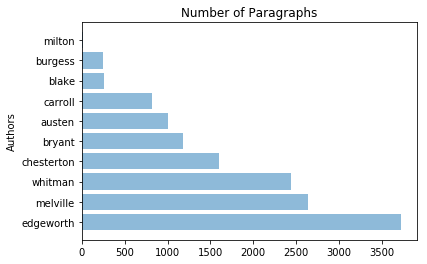

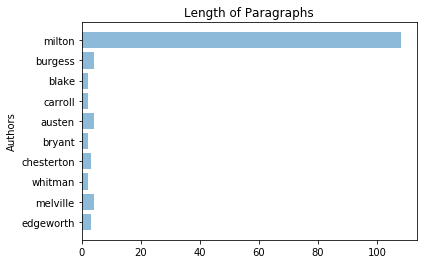

In [19]:
# Graph for the number of paragraphs for each author
y_pos = np.arange(len(author_count_df.number_of_paragraphs)) 
plt.barh(y_pos, author_count_df.number_of_paragraphs, align='center', alpha=0.5)
plt.yticks(y_pos, author_count_df.authors)
plt.ylabel('Authors')
plt.title('Number of Paragraphs') 
plt.show()

# Graph for the average length of paragraphs for each author
y_pos = np.arange(len(author_count_df.paragraph_length)) 
plt.barh(y_pos, author_count_df.paragraph_length, align='center', alpha=0.5)
plt.yticks(y_pos, author_count_df.authors)
plt.ylabel('Authors')
plt.title('Length of Paragraphs')
plt.show()

One of the take aways from visualizing the authors and the paragraph dataset is that there is an important distinction between the number of paragraphs and the length of paragraphs. As you can see from the visualization above, John Milton has very few paragraphs compared to all the other authors but he makes up for it by having extremely long paragraphs. This will likely affect my clusters and models because Milton is the outlier.

## Feature Generation

Now that I've created a dataframe and visualized some of the distribution for my dataset, I'm going to create features that I can use for modeling. 

In [20]:
# Defining my X and Y variables
X = paragraph_df.paragraphs
Y = paragraph_df.author_codes

In [45]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=6, # only use words that appear at six times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
paragraph_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % paragraph_tfidf.get_shape()[1])

#splitting into training and test sets. Reserving 25% of my corpus as a test set.
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(paragraph_tfidf, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=0)

Number of features: 4179


Because of my large number of features, I want to reduce it to the most valuable components. I am going to use a loop and a Singular Value Decomposition(SVD) to get a better sense of how many components are needed to capture 50% of the variance for my dataset.  

In [24]:
for i in range(200, 1100, 200):
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print(i)
    print("Percent variance captured by all components:",total_variance*100)

200
Percent variance captured by all components: 33.324471111767906
400
Percent variance captured by all components: 46.77837565066583
600
Percent variance captured by all components: 56.161878622526885
800
Percent variance captured by all components: 63.499196088147805
1000
Percent variance captured by all components: 69.50808732691449


In [46]:
# From the code above, I'm going to reduce the feature space from 4179 to 500. 
svd= TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 51.815549996354434


(array([67., 66., 58., 53., 41., 32., 25., 19., 13., 11., 11., 10.,  8.,
         6.,  7.,  5.,  4.,  3.,  5.,  4.,  5.,  4.,  3.,  3.,  4.,  4.,
         0.,  3.,  1.,  2.,  2.,  2.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  2.,  1.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00041715, 0.00049552, 0.0005739 , 0.00065227, 0.00073064,
        0.00080902, 0.00088739, 0.00096577, 0.00104414, 0.00112252,
        0.00120089, 0.00127927, 0.00135764, 0.00143601, 0.00151439,
        0.00159276, 0.00167114, 0.00174951, 0.00182789, 0.00190626,
        0.00198464, 0.00206301, 0.00214138, 0.00221976, 0.00229813,
        0.00237651, 0.00245488, 0.00253326, 0.00261163, 0.00269   ,
        0.00276838, 0.0028

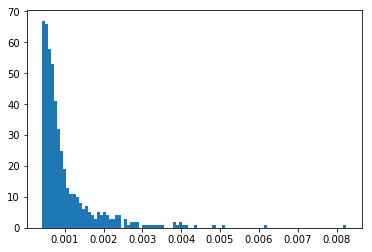

In [26]:
# This is a histogram showing that many of the components explain very little about the dataset and its variance. 
plt.hist(variance_explained, bins=100)

## Clustering/Unsupervised Modeling

To begin my clustering of authors, I used KMeans, MeanShift, and MiniBatchKMeans as my techniques. My impression is that none of the clustering methods performed very well. I tested out many different size of clusters but none of them were able to consistently group the authors. I chose to use 10 as my desired number of clusters given that I have 10 authors that are in my dataframe. 

In [43]:
# Normalize the data.
X_norm = normalize(X_train_lsa)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_norm)

# Check the solution against the data.
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train, y_pred))

Comparing k-means clusters against authors:
col_0           0    1    2     3    4    5    6   7    8    9
author_codes                                                  
0               3    0    3   307   27   30  178  10    3   19
1               0    0   86   917   17   57    4   0   35  710
2              64    0  109  1076  288   24   80  32   28  241
3               0    0    0     5    0    0    0   0    0    6
4              35    0   28   305   14   23   44  24  260   20
5               0    0    3   116   19    5    4   4    3   50
6               0    0   53   462  132   19  154  21    3   47
7               0    0    3   107   43   10   10   2    3    4
8              16  179   77   615   16   28  198  14    8   50
9             103    0  154  1564   64  139  401  66  234  125


The K means clustering does not start out showing any meaningful grouping of the datapoints.

In [41]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,labels))

Number of estimated clusters: 1
Comparing the assigned categories to the ones in the data:
col_0            0
author_codes      
0              580
1             1826
2             1942
3               11
4              753
5              204
6              891
7              182
8             1201
9             2850


The Mean Shift clustering performed very poorly because it decided that there was only one cluster in the dataset.

In [30]:
from sklearn.cluster import MiniBatchKMeans

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_train_lsa)

# Check the MiniBatch model against the training set.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(Y_train, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0           0    1   2   3    4    5    6    7    8     9
author_codes                                                 
0              33    3   0   0   40   23   11  171   16   283
1              62    0  69   3  123  169  160    3   27  1210
2              60   67  92   0  445   73   51   82   65  1007
3               0    0   0   0    1    1    0    0    0     9
4              26   40  17   0   35   27   20   51   43   494
5               4    0   4   0   28   29   10    4    6   119
6              23    0  34   0  175   35   37  145   46   396
7              10    0   0   0   51    6    2   10    6    97
8              33   19  88   0   55   15    5  270   36   680
9             122  108  83  35  173  114  209  363  181  1462


Before I move onto the Supervised modeling, I'm going to use my 25% reserve corpus test set on the MiniBatchKMeans model. I chose this model because it appeared to do a little better at separating some of the authors into separate groups. The test sample below shows that it does not appear to do any better at consistently separating the authors into their own clusters. 

In [48]:
# Add the new predicted cluster memberships to the data frame.
test_predict = minibatchkmeans.predict(X_test_lsa)

# Check the MiniBatch model against our earlier one.
print('Comparing mini batch k-means solutions and the test group:')
print(pd.crosstab(Y_test, test_predict))

Comparing mini batch k-means solutions and the test group:
col_0          0   1   2   3    4   5   6    7   8    9
author_codes                                           
0             18   0   4   0   17   7   7   61   8  112
1             15   0  27   1   56  60  44    2  10  395
2             24  27  40   0  169  35  14   19  15  351
3              0   0   2   0    0   2   0    0   0    2
4              7  12   6   0   17  10   7   13  16  166
5              0   0   0   0    7  11  10    1   1   21
6              2   0  12   0   67  12  14   41  17  130
7              2   0   1   0   18   4   0    2   1   33
8             18   2  34   0   24  10   1  104  13  198
9             38  27  16  14   64  37  63  125  49  438


## Supervised Modeling

Next, I am going to compare how several supervised models compare in their classification of the texts by author. 

In [52]:
# Random Forest Classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_lsa,Y_train)
print(rfc)
print('Training set score:', rfc.score(X_train_lsa,Y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training set score: 0.9450191570881226


In [53]:
print("Report:")
y_true, y_pred = Y_test, rfc.predict(X_test_lsa)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.51      0.32      0.39       234
          1       0.50      0.64      0.56       610
          2       0.56      0.54      0.55       694
          3       0.00      0.00      0.00         6
          4       0.60      0.47      0.53       254
          5       0.12      0.02      0.03        51
          6       0.42      0.29      0.34       295
          7       0.83      0.31      0.45        61
          8       0.65      0.45      0.54       404
          9       0.51      0.68      0.58       871

avg / total       0.53      0.53      0.52      3480



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 74,  23,  23,   0,   9,   0,  14,   0,   9,  82],
       [  9, 392,  84,   0,   4,   3,  13,   1,  19,  85],
       [ 10, 138, 378,   0,  13,   0,  21,   1,  21, 112],
       [  0,   5,   1,   0,   0,   0,   0,   0,   0,   0],
       [  8,  19,  24,   0, 120,   1,   6,   1,   3,  72],
       [  1,  25,  12,   0,   0,   1,   4,   0,   0,   8],
       [ 13,  52,  36,   0,   7,   1,  86,   1,  18,  81],
       [  1,   2,   7,   0,   0,   0,   8,  19,   2,  22],
       [ 10,  43,  31,   0,   9,   1,  23,   0, 183, 104],
       [ 18,  86,  84,   0,  37,   1,  30,   0,  25, 590]])

In [54]:
RFC_score = cross_val_score(rfc, X_test_lsa, Y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', RFC_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.45285714 0.47701149 0.46264368 0.46695402 0.48121387]

Overall Random Forest Classifier Accuracy: 0.47 (+/- 0.02)



In this Random Forest Classifier I see that it performs poorly with a large amount of overfitting. My accuracy score is very bad a 0.47. The only thing that I'm happy to see in this model is that the confusion matrix is better than previous times when I was first working with my data. 

In [55]:
lr = LogisticRegression()
lf_model = lr.fit(X_train_lsa,Y_train)
print(lf_model)
print('Training set score:', lr.score(X_train_lsa,Y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training set score: 0.7524904214559387


In [56]:
print("Report:")
y_true, y_pred = Y_test, lr.predict(X_test_lsa)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.97      0.49      0.65       234
          1       0.66      0.80      0.73       610
          2       0.78      0.67      0.72       694
          3       0.00      0.00      0.00         6
          4       0.91      0.58      0.71       254
          5       1.00      0.04      0.08        51
          6       0.64      0.53      0.58       295
          7       0.93      0.46      0.62        61
          8       0.77      0.62      0.69       404
          9       0.60      0.88      0.72       871

avg / total       0.73      0.69      0.69      3480



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[114,  12,  15,   0,   1,   0,  15,   0,   8,  69],
       [  0, 488,  31,   0,   2,   0,   7,   0,   8,  74],
       [  0,  82, 463,   0,   3,   0,  12,   0,  19, 115],
       [  0,   4,   0,   0,   0,   0,   0,   0,   1,   1],
       [  0,  10,  12,   0, 147,   0,   5,   0,   8,  72],
       [  0,  33,   6,   0,   0,   2,   5,   0,   1,   4],
       [  0,  30,  17,   0,   3,   0, 155,   2,  14,  74],
       [  0,   3,   3,   0,   0,   0,   7,  28,   2,  18],
       [  1,  30,  23,   0,   0,   0,  23,   0, 250,  77],
       [  3,  43,  25,   0,   5,   0,  13,   0,  14, 768]])

In [57]:
LR_score = cross_val_score(lr, X_test_lsa, Y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.66571429 0.65948276 0.62787356 0.63218391 0.65317919]

Overall Logistic Regression Accuracy: 0.65 (+/- 0.03)



The Logistic Regression model is a major improvement to all previous models. It has less overfitting and its end accuracy score is 0.65. 

In [58]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train_lsa,Y_train)
print(svc_model)
print('Training set score:', svc_model.score(X_train_lsa,Y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training set score: 0.7683908045977011


In [59]:
print("Report:")
y_true, y_pred = Y_test, svc.predict(X_test_lsa)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.91      0.49      0.64       234
          1       0.65      0.78      0.71       610
          2       0.76      0.66      0.71       694
          3       0.00      0.00      0.00         6
          4       0.91      0.60      0.72       254
          5       0.52      0.22      0.31        51
          6       0.61      0.53      0.57       295
          7       0.89      0.56      0.69        61
          8       0.78      0.65      0.71       404
          9       0.62      0.86      0.72       871

avg / total       0.71      0.69      0.69      3480



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[114,  17,  16,   0,   1,   1,  16,   0,   8,  61],
       [  1, 475,  41,   0,   2,   4,  13,   0,   5,  69],
       [  2,  88, 458,   0,   2,   1,  15,   1,  21, 106],
       [  0,   4,   0,   0,   0,   0,   0,   0,   1,   1],
       [  1,   9,  10,   0, 152,   0,   4,   0,   8,  70],
       [  0,  29,   4,   0,   0,  11,   3,   1,   0,   3],
       [  2,  29,  24,   0,   2,   3, 156,   1,  13,  65],
       [  0,   4,   4,   0,   0,   1,   3,  34,   3,  12],
       [  2,  28,  16,   0,   0,   0,  26,   1, 261,  70],
       [  3,  45,  30,   0,   8,   0,  19,   0,  15, 751]])

In [60]:
SVC_score = cross_val_score(svc, X_test_lsa, Y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', SVC_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (SVC_score.mean(), SVC_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.65142857 0.65517241 0.62212644 0.61925287 0.6416185 ]

Overall Logistic Regression Accuracy: 0.64 (+/- 0.03)



This Support Vector Classifier had a similar performance to the logistic regression model. The only difference being that its accuracy is slightly lower at 0.64. 

# Conclusion

Now as I compare clustering and modeling with their ability to accurately classify the text, I would say that modeling easily out performed clustering. 
    
The results from clustering were confusing and inconsistent. Clustering is somewhat of a black box that is difficulty to assess how or why it is connecting datapoints. I find that this makes it hard for a beginner to like myself to get a sense of how I can improve the clusters since so little about the clusters is easily communicated by the program. An advantage of unsupervised models and clustering in general is that they are good at exploring complicated dataset and making connections that supervised models can't make.
    
The supervised modeling that I used had much better and consistent outcomes. While there were some signs of overfitting, the models successfully separated out the majority of authors and their texts for both the logistic and support vector models. The advantages of modeling is that you can gain a much better perspective of how the data is organized and behaving. I would use modeling over clustering if I am trying to create a more explanatory model for the data.